# Прототип модели машинного обучения для золотодобывающей компании

## Задача

Компания «Цифра» разрабатывает решения для эффективной работы промышленных предприятий.\
Необходимо подготовить прототип модели машинного обучения:
- Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.
- Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В распоряжении данные с параметрами добычи и очистки. 

## 1. Загрузка и подготовка данных

#### Импорт необходимых для работы библиотек, метрик и утилит

In [1]:
#!pip install sweetviz

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv

# импорт моделей
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import MinMaxScaler

# настройки
import warnings
warnings.filterwarnings("ignore")

# константа верхний регистр
RANDOM_STATE = 42

#### Загрузка данных

Данные находятся в трёх файлах:
- **gold_recovery_train_new.csv** - обучающая выборка = **df_train**
- **gold_recovery_test_new.csv** - тестовая выборка = **df_test**
- **gold_recovery_full_new.csv** - исходные данные = **df_full**

In [3]:
# загрузим данные
df_train = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\gold_recovery_train_new.csv')
df_test = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\gold_recovery_test_new.csv')
df_full = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\gold_recovery_full_new.csv')

#### Описание данных

##### Технологический процесс:

- **Rougher feed** — исходное сырье
- **Rougher additions** (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
-- **Xanthate** — ксантогенат (промотер, или активатор флотации);
-- **Sulphate** — сульфат (на данном производстве сульфид натрия);
-- **Depressant** — депрессант (силикат натрия).
- **Rougher process** (англ. «грубый процесс») — флотация
- **Rougher tails** — отвальные хвосты
- **Float banks** — флотационная установка
- **Cleaner process** — очистка
- **Rougher Au** — черновой концентрат золота
- **Final Au** — финальный концентрат золота

##### Параметры этапов:

- **air amount** — объём воздуха
- **fluid levels** — уровень жидкости
- **feed size** — размер гранул сырья
- **feed rate** — скорость подачи

In [4]:
# изучим исходные данные при помощи библиотеки Sweetviz
# report = sv.analyze([df_full, 'Исходные данные'])
# report.show_html('Исходные данные.html')

In [5]:
# сравним обучающую и тестовую выборки с помощью библиотеки Sweetviz
# report = sv.compare([df_train, 'Обучающая выборка'], [df_test, 'Тестовая выборка'])
# report.show_html('df.html')

#### Выводы

1. Количество признаков в обучающей и тестовой выборках различное
2. Достаточно много пропусков
3. Не соответствие типа данных в столбце "date"
4. Распределение большинства признаков на гистограммах в большинстве случаев скошеннное, с хвостами

##### Посмотрим на данные таблицах "df_train" и "df_test"  подробнее:

In [6]:
# функция для получения общей информации о данных
def get_info(data):
    display(data.head())
    display(data.tail())
    display(data.info())
    display(data.describe())
    print('\nРазмер таблицы:', data.shape)
    print('\nКоличество явных дубликатов:', data.duplicated().sum())
    print('\nКоличество пропусков в таблице:', data.isna().sum().sum())

In [7]:
# общая информация о обучающей выборке
get_info(df_train)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
14144,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
14145,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
14146,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
14147,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
14148,2018-08-18 10:59:59,3.598375,11.737832,6.717509,46.299438,70.281454,8.406690,2.517518,10.652193,1.389434,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459



Размер таблицы: (14149, 87)

Количество явных дубликатов: 0

Количество пропусков в таблице: 4100


In [8]:
# общая информация о тестовой выборке
get_info(df_test)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5285,2017-12-31 19:59:59,173.957757,15.963399,8.07,0.896701,1401.930554,-499.728848,1401.441445,-499.193423,1399.810313,...,13.995957,-500.157454,12.069155,-499.673279,7.977259,-499.516126,5.933319,-499.965973,8.987171,-499.755909
5286,2017-12-31 20:59:59,172.910270,16.002605,8.07,0.896519,1447.075722,-494.716823,1448.851892,-465.963026,1443.890424,...,16.749781,-496.031539,13.365371,-499.122723,9.288553,-496.892967,7.372897,-499.942956,8.986832,-499.903761
5287,2017-12-31 21:59:59,171.135718,15.993669,8.07,1.165996,1498.836182,-501.770403,1499.572353,-495.516347,1502.749213,...,19.994130,-499.791312,15.101425,-499.936252,10.989181,-498.347898,9.020944,-500.040448,8.982038,-497.789882
5288,2017-12-31 22:59:59,179.697158,15.438979,8.07,1.501068,1498.466243,-500.483984,1497.986986,-519.200340,1496.569047,...,19.958760,-499.958750,15.026853,-499.723143,11.011607,-499.985046,9.009783,-499.937902,9.012660,-500.154284
5289,2017-12-31 23:59:59,181.556856,14.995850,8.07,1.623454,1498.096303,-499.796922,1501.743791,-505.146931,1499.535978,...,20.034715,-500.728588,14.914199,-499.948518,10.986607,-500.658027,8.989497,-500.337588,8.988632,-500.764937


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487



Размер таблицы: (5290, 53)

Количество явных дубликатов: 0

Количество пропусков в таблице: 90


##### Оценим сколько пропусков в процентном отношении:

In [9]:
# пропуски в процентах
def lost(data):
    if data.isna().sum().sum()>0:
        display(
            (round(data.isna().mean()*100,3))
            .to_frame()
            .rename(columns = {0:'Пропуски'})
            .query('Пропуски > 0')
            .sort_values(by = 'Пропуски', ascending = False)
            .style.background_gradient('coolwarm')
        )
    else:
        print('Пропусков нет')

In [10]:
lost(df_train)

,Пропуски
secondary_cleaner.output.tail_sol,11.344000
rougher.state.floatbank10_e_air,3.081000
rougher.input.floatbank11_xanthate,3.025000
primary_cleaner.output.concentrate_sol,2.021000
secondary_cleaner.state.floatbank2_a_air,1.534000
final.output.concentrate_sol,1.491000
rougher.input.feed_size,1.018000
final.output.tail_pb,0.707000
rougher.input.feed_pb,0.707000
primary_cleaner.input.xanthate,0.707000


In [11]:
lost(df_test)

,Пропуски
rougher.input.floatbank11_xanthate,0.473000
rougher.input.feed_sol,0.397000
secondary_cleaner.state.floatbank3_a_air,0.170000
rougher.input.floatbank11_sulfate,0.151000
primary_cleaner.input.depressant,0.095000
rougher.input.floatbank10_sulfate,0.095000
primary_cleaner.input.sulfate,0.076000
primary_cleaner.input.xanthate,0.076000
rougher.input.feed_rate,0.057000
secondary_cleaner.state.floatbank2_a_air,0.057000


#### Выводы

1. Пропусков в обучающей выборке более 11% и удаление такого количества строк может повлиять на обучение модели.
2. Нужна будет стратегия заполнения пропусков.
3. Признаки в тестовой и обучающей выборках необходимо сопоставить, иначе мы будем учить по признакам, которых в тестовой выборке нет.

### 1.2. Эффективность обогащения рассчитывается по формуле

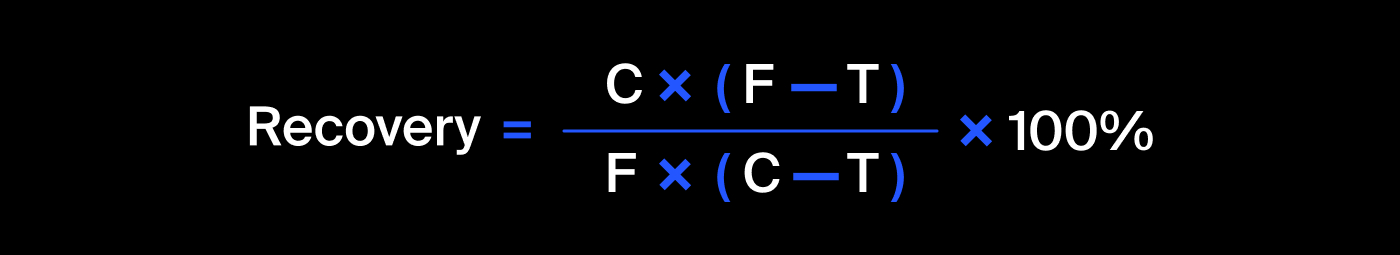

где:
- **F** - доля золота в сырье/концентрате до флотации/очистки
- **T** - доля золота в отвальных хвостах после флотации/очистки
- **C** - доля золота в концентрате после флотации/очистки;

In [12]:
F = df_train['rougher.input.feed_au']          # доля золота в сырье до очистки (вход)
T = df_train['rougher.output.tail_au']         # доля золота в отвальных хвостах после очистки (выход)
C = df_train['rougher.output.concentrate_au']  # доля золота в концентрате после очистки (выход)

#### Вычислим **Recovery** на обучающей выборке для признака rougher.output.recovery

In [13]:
# эффективность восстановления
recovery = (C * (F-T)) / (F * (C-T)) * 100

#### Найдем MAE между нашими расчётами и значением признака

In [14]:
# среднее значение эффективности обогащения по нашим рассчетам
mean_recovery = recovery.mean()

In [15]:
# среднее значение эффективности обогащения по обучающей выборке
mean_rougher_output_recovery  = df_train['rougher.output.recovery'].mean()

In [16]:
# средняя абсолютная ошибка между рассчетами и данными обучающей выборки
mae = mean_absolute_error(recovery, df_train['rougher.output.recovery'])

In [17]:
print('Среднее значение эффективности обогащения руды по рассчетам: ', '\033[1m'+ f'{mean_recovery:,.3f}' +'\033[0m')
print('='*80)
print('Среднее значение эффективности  обогащения руды в обучающей выборке: ', '\033[1m'+ f'{mean_rougher_output_recovery:,.3f}' +'\033[0m')
print('='*80)
print('Средняя абсолютная ошибка, MAE: ', '\033[1m'+ f'{mae}' +'\033[0m')

Среднее значение эффективности обогащения руды по рассчетам:  82.705
Среднее значение эффективности  обогащения руды в обучающей выборке:  82.705
Средняя абсолютная ошибка, MAE:  9.73512347450521e-15


## Выводы

1. Среднее значение эффективности обогащения по рассченой формуле и в обучающей выборке совпадают.
2. Средняя абсолютная ошибка имеет небольшое отклонение, что подтверждает совпадение рассчетных значений recovery и значений recovery в rougher_output_recovery обучающей выборки.

### 1.3. Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [18]:
# столбцы в тестовой выборке
set(df_test.columns)

{'date',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_au',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

In [19]:
# столбцы в обучающей выборке
set(df_train.columns)

{'date',
 'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.s

In [20]:
# столбцы недоступные в df_test
missing_columns = list(set(df_train.columns) - set(df_test.columns))
set(missing_columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

## Выводы

1. В тестовой выборке отсутствуют целевые признаки: 
- **rougher.output.recovery** - эффективность обогащения чернового концентрата
- **final.output.recovery** - эффективность обогащения финального концентрата 
2. В тестовой выборке присутствуют:
 - **primary_cleaner** - параметры сырья и параметры текущего состояния этапа первичной очистки
 - **rougher.input** - параметры флотационной установки для сырья и реагентов
 - **secondary_cleaner** - параметры текущего состояния этапа вторичной очистки

### 1.4. Проведем предобработку данных

### 1.4.1. Пропуски
Судя по столбцу "date" - значения технологических процессов записываются с периодичностью в один час.\
Можно предположить, что соседние значения несильно отличаются и пропуски в столбцах можно заполнить значением сверху или снизу.

In [21]:
# заполним пропуски в предыдущим значением в столбцах
df_train.ffill(axis=0, inplace=True)
df_test.ffill(axis=0, inplace=True)
df_full.ffill(axis=0, inplace=True)

In [22]:
# первая строка может не заполнится, проэтому проверим
lost(df_train)

Пропусков нет


In [23]:
# проверим тестововую выборку
lost(df_test)

Пропусков нет


In [24]:
# проверим полные данные
lost(df_full)

Пропусков нет


### 1.4.2. Недостающие признаки в тестовой выборке

In [25]:
# добавим целевые признаки в тестовую выборку
df_test = df_test.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how = 'left', on = 'date')

### 1.4.3. Избыточные признаки в выборках

In [26]:
# удалим признаки отсутсвующие в тестовой быдорке
df_train = df_train.drop(missing_columns, axis=1)

In [27]:
# добавим целевые признаки в обучающую выборку
df_train = df_train.merge(df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how = 'left', on = 'date')

In [28]:
# столбцы с датой удалим, они не потребуются для обучения модели
df_train.drop(['date'], axis=1, inplace=True)
df_test.drop(['date'], axis=1, inplace=True)

In [29]:
# результат 
df_train.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198
2,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,68.116445
3,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430,68.347543
4,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794,66.927016


In [30]:
# результат
df_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,87.360133,67.776393
4,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,83.236367,61.467078


## 2. Проанализируем данные

### 2.1. Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки 

- Концентрация в сырье - rougher.input.feed
- Концентрация после флотации - rougher.output.concentrate
- Концентрация после первичной очистки - primary_cleaner.output.concentrate
- Финальная концентрация -final.output.concentrate

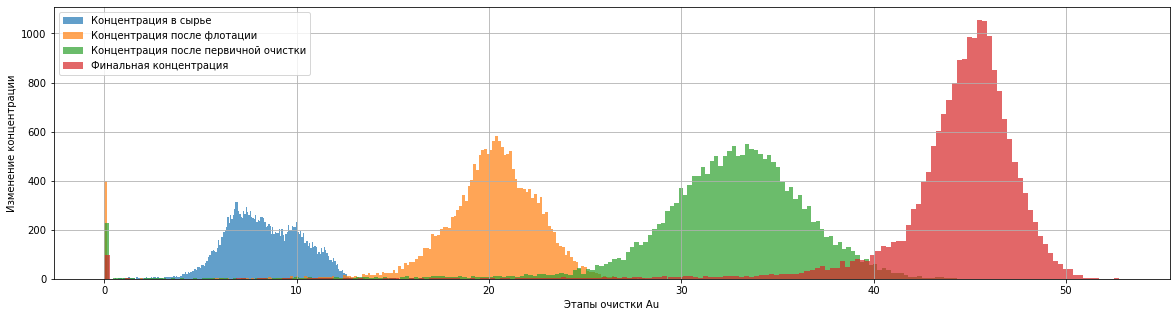

In [31]:
# гистограммы изменения концентрации золота на разных этапах очистки
fig, axis = plt.subplots(figsize=(20,5))

df_full['rougher.input.feed_au'].hist(bins=200, alpha=0.7, label='Концентрация в сырье')
df_full['rougher.output.concentrate_au'].hist(bins=200, alpha=0.7, label='Концентрация после флотации')
df_full['primary_cleaner.output.concentrate_au'].hist(bins=200, alpha=0.7, label='Концентрация после первичной очистки')
df_full['final.output.concentrate_au'].hist(bins=200, alpha=0.7, label='Финальная концентрация')

plt.xlabel('Этапы очистки Au')
plt.ylabel('Изменение концентрации')
plt.legend();

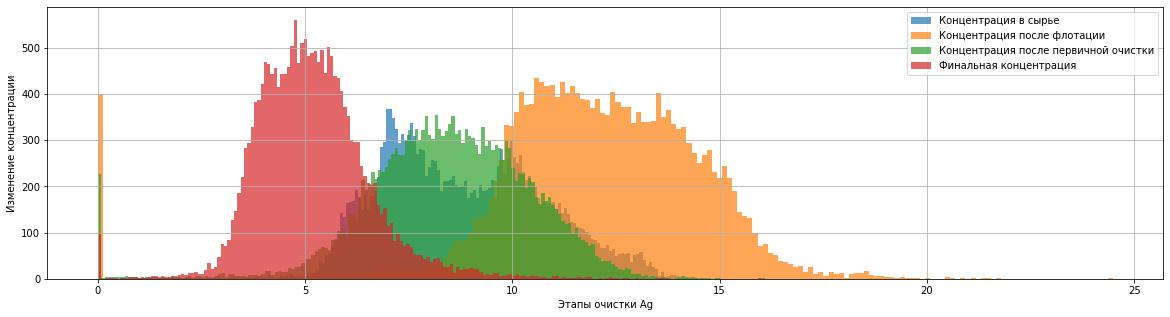

In [32]:
# гистограммы изменения концентрации серебра на разных этапах очистки
fig, axis = plt.subplots(figsize=(20,5))

df_full['rougher.input.feed_ag'].hist(bins=200, alpha=0.7, label='Концентрация в сырье')
df_full['rougher.output.concentrate_ag'].hist(bins=200, alpha=0.7, label='Концентрация после флотации')
df_full['primary_cleaner.output.concentrate_ag'].hist(bins=200, alpha=0.7, label='Концентрация после первичной очистки')
df_full['final.output.concentrate_ag'].hist(bins=200, alpha=0.7, label='Финальная концентрация')

plt.xlabel('Этапы очистки Ag')
plt.ylabel('Изменение концентрации')
plt.legend();

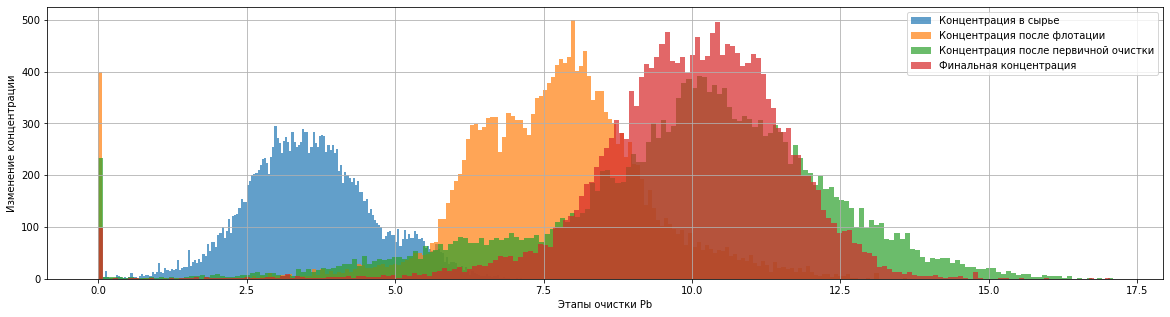

In [33]:
# гистограммы изменения концентрации свинца на разных этапах очистки
fig, axis = plt.subplots(figsize=(20,5))

df_full['rougher.input.feed_pb'].hist(bins=200, alpha=0.7, label='Концентрация в сырье')
df_full['rougher.output.concentrate_pb'].hist(bins=200, alpha=0.7, label='Концентрация после флотации')
df_full['primary_cleaner.output.concentrate_pb'].hist(bins=200, alpha=0.7, label='Концентрация после первичной очистки')
df_full['final.output.concentrate_pb'].hist(bins=200, alpha=0.7, label='Финальная концентрация')

plt.xlabel('Этапы очистки Pb')
plt.ylabel('Изменение концентрации')
plt.legend();

#### Выводы

1. Концентрация золота последовательно увеличивается на каждом этапе очистки и становится максимально в финале очистки.
2. Концентрация серебра примерна одинакова на всех этапах, лишь в финальном она выше, чем в исходном сырье, но при этом почти в два раза меньше, чем концентрация золота.
3. Концентрация свинца также заметно растет к финальному этапу, но тоже почти в два раза меньше концентрации золота.

### 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках
Если распределения сильно отличаются друг от друга, оценка модели будет неправильной

In [34]:
# оценим статистические показатели
df_train['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [35]:
# оценим статистические показатели
df_test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

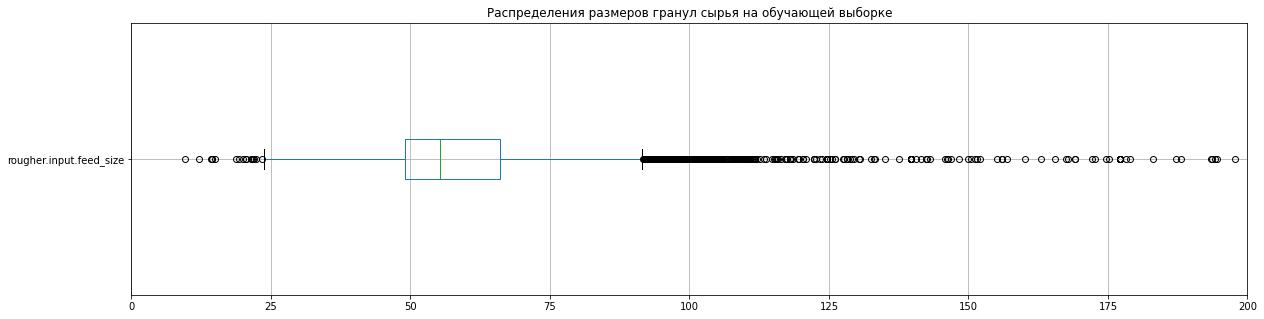

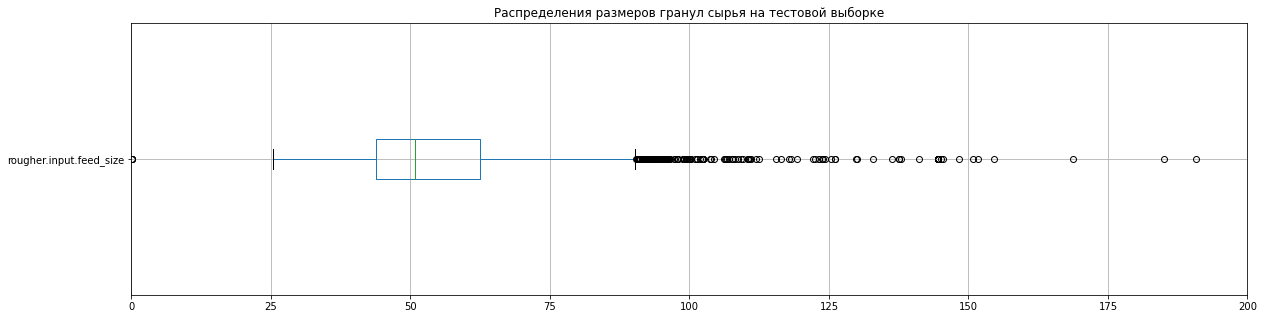

In [36]:
# построим диаграммы размаха размеров гранул для обучающей и тестовой выборок

fig, ax = plt.subplots(figsize = (20,5))
ax = df_train[['rougher.input.feed_size']].boxplot(vert = False, ax =ax)
ax.set_title('Pаспределения размеров гранул сырья на обучающей выборке')
ax.set_xlim(0, 200);

fig, ax = plt.subplots(figsize = (20,5))
ax = df_test[['rougher.input.feed_size']].boxplot(vert = False, ax =ax)
ax.set_title('Pаспределения размеров гранул сырья на тестовой выборке')
ax.set_xlim(0, 200);

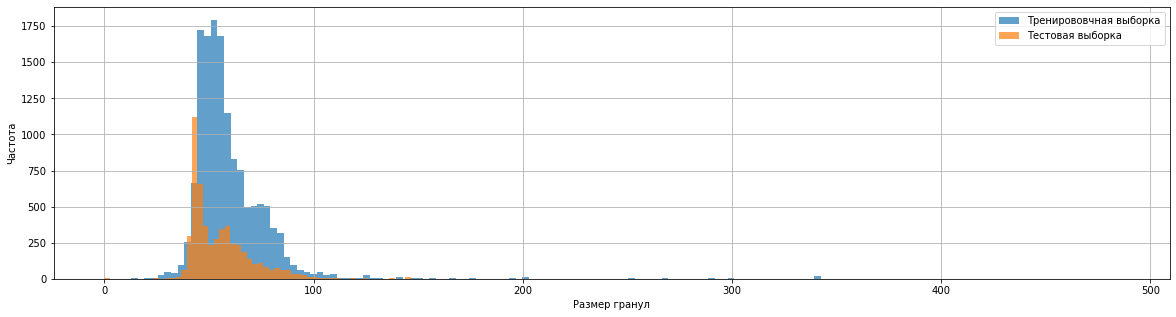

In [37]:
# гистограммы распределения размеров гранул
fig, axis = plt.subplots(figsize=(20,5))

df_train['rougher.input.feed_size'].hist(bins=150, alpha=0.7, label='Тренирововчная выборка')
df_test['rougher.input.feed_size'].hist(bins=150, alpha=0.7, label='Тестовая выборка')

plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.legend();

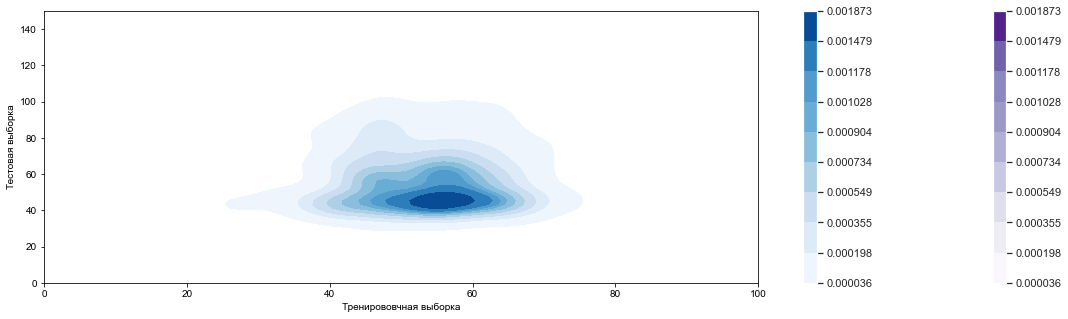

In [38]:
# построим график оценки распределения 
f, ax = plt.subplots(figsize=(20, 5))
sns.set(style='dark',)
res = sns.kdeplot(df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size'], shade=True, cmap='Purples', cbar=True)
res = sns.kdeplot(df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size'], shade=True, cmap='Blues', cbar=True)
plt.xlabel('Тренирововчная выборка')
plt.ylabel('Тестовая выборка')

plt.xlim([0, 100])
plt.ylim([0, 150])
plt.show()

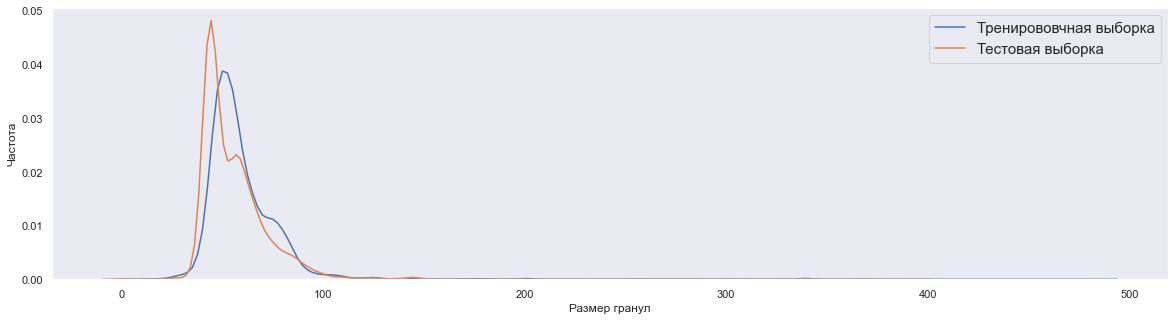

In [39]:
# график оценки распределения 
f, ax = plt.subplots(figsize=(20, 5))

sns.kdeplot(x='rougher.input.feed_size', bw_adjust=0.9, label='Тренирововчная выборка',data=df_train);
sns.kdeplot(x='rougher.input.feed_size', bw_adjust=0.9, label='Тестовая выборка', data=df_test);

plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.legend(fontsize = 15);


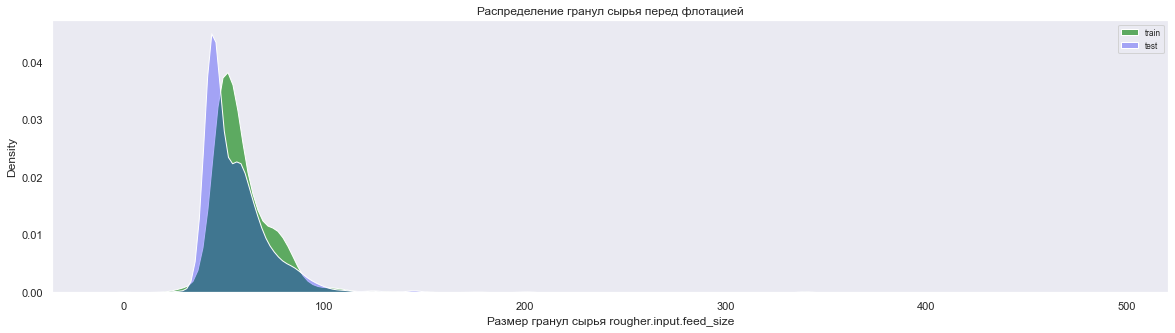

In [40]:
plt.figure(figsize=[20,5])

sns.kdeplot(df_train["rougher.input.feed_size"], label="train",multiple= 'stack', alpha= .6, color='green')
sns.kdeplot(df_test["rougher.input.feed_size"], label="test", multiple= 'stack', alpha= .3, color='blue')

plt.xlabel("Размер гранул сырья rougher.input.feed_size")
plt.legend(loc='upper right', fontsize='x-small')
plt.title("Распределение гранул сырья перед флотацией");


#### Выводы

1. На графиках размеры гранул в выборках визуально можно оценить, как близкие по размеру.
2. Медиана - 50 и 55, стандартное отклонение значений - 23 и 19 в обучающей и тестовой соответственно.

### 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

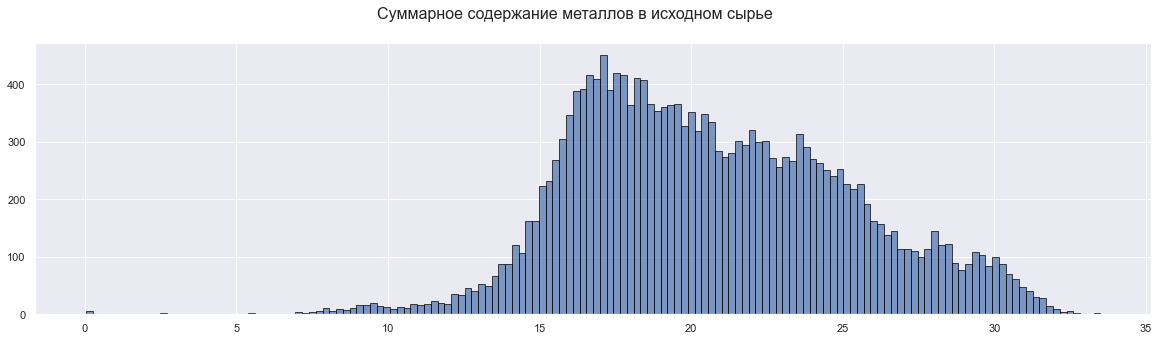

In [41]:
fig, axis = plt.subplots(figsize=(20,5))
fig.suptitle('Суммарное содержание металлов в исходном сырье', fontsize=16)

# концентрация в сырье всех металлов
df_full[['rougher.input.feed_au',
         'rougher.input.feed_ag',
         'rougher.input.feed_pb']].sum(axis=1).hist(bins=150, alpha=0.7, edgecolor='black', linewidth=1);

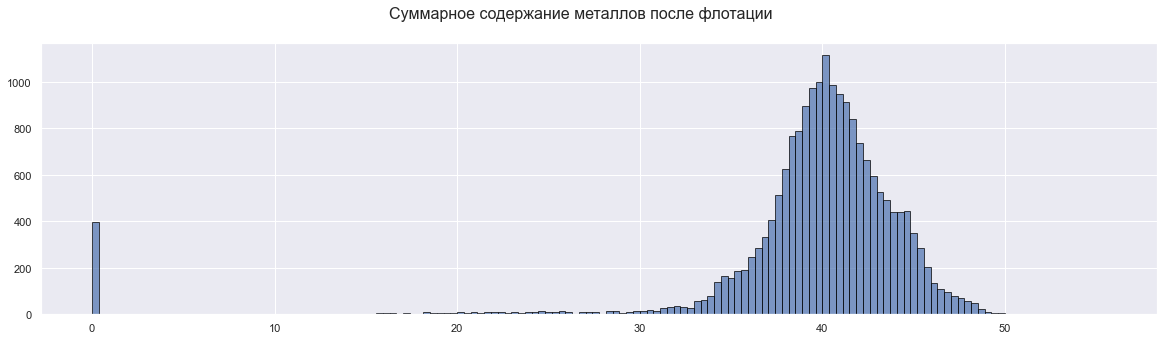

In [42]:
fig, axis = plt.subplots(figsize=(20,5))
fig.suptitle('Суммарное содержание металлов после флотации', fontsize=16)

# концентрация всех металлов после черновой очистки
df_full[['rougher.output.concentrate_au',
         'rougher.output.concentrate_ag',
         'rougher.output.concentrate_pb']].sum(axis=1).hist(bins=150, alpha=0.7, edgecolor='black', linewidth=1);

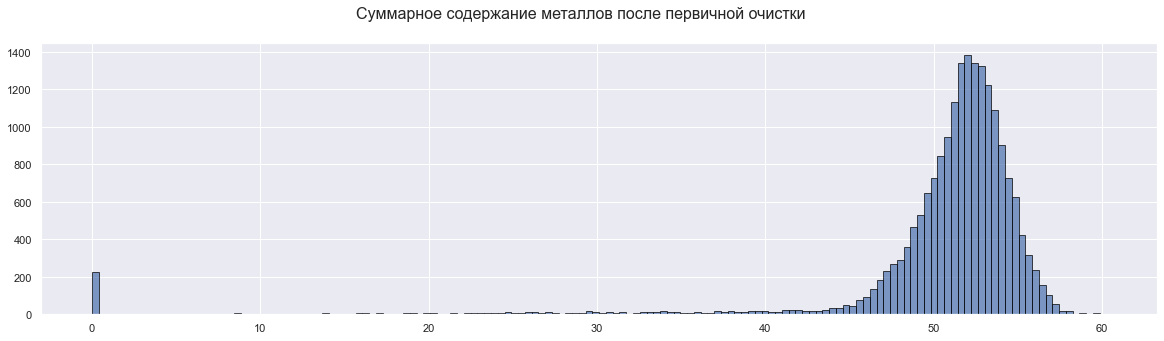

In [43]:
fig, axis = plt.subplots(figsize=(20,5))
fig.suptitle('Суммарное содержание металлов после первичной очистки', fontsize=16)

# концентрация всех металлов после черновой очистки
df_full[['primary_cleaner.output.concentrate_au',
         'primary_cleaner.output.concentrate_ag',
         'primary_cleaner.output.concentrate_pb']].sum(axis=1).hist(bins=150, alpha=0.7, edgecolor='black', linewidth=1);

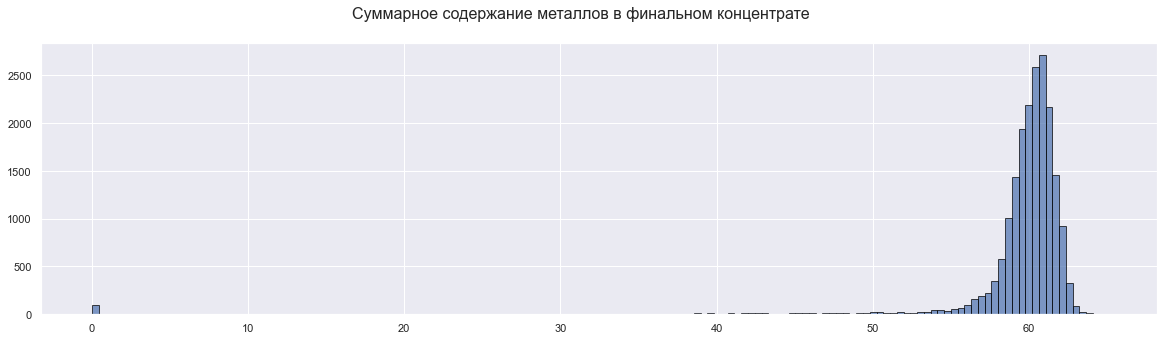

In [44]:
fig, axis = plt.subplots(figsize=(20,5))
fig.suptitle('Суммарное содержание металлов в финальном концентрате', fontsize=16)

# концентрация всех металлов после финальной очистки
df_full[['final.output.concentrate_au',
         'final.output.concentrate_ag',
         'final.output.concentrate_pb']].sum(axis=1).hist(bins=150, alpha=0.7, edgecolor='black', linewidth=1);

#### Выводы

1. Определяются нулевые значения на этапах обработки, особенно много после этапа флотации.
2. Этих и значений нет в обучающей и тестовой выборках, только признаки исходного сырья. 
3. Чтобы избежать воздействие нулей на модель удалим их в тех признаках, которые есть в обучающей выборке.

In [45]:
# удаляем нулевые значения
df_train = df_train.drop(index = df_train[df_train['rougher.input.feed_au'] <= 0.1].index, axis = 0)
df_train = df_train.drop(index = df_train[df_train['rougher.input.feed_ag'] <= 0.1].index, axis = 0)
df_train = df_train.drop(index = df_train[df_train['rougher.input.feed_pb'] <= 0.1].index, axis = 0)

## 3. Построим модель

#### Подготовим выборки для целевого признака **rougher.output.recovery**

In [46]:
# оставим в тренеровочной и тестовой выборках только признаки флотации
train_roug = df_train.filter(regex='^rougher',axis=1)
test_roug = df_test.filter(regex='^rougher',axis=1)

In [47]:
# извлекаем признаки для обучающей и тестовой выборок
features_train_roug = train_roug.drop(['rougher.output.recovery'], axis=1) 
features_test_roug = test_roug.drop(['rougher.output.recovery'], axis=1)                

In [48]:
# извлечем целевой признак для обучающей и тестовой выборок
target_train_roug = train_roug['rougher.output.recovery'] 
target_test_roug = test_roug['rougher.output.recovery']                  

#### Подготовим выборки для целевого признака **final.output.recovery**

In [49]:
# сохраним обучающую и тестовую выборки в новых переменных для единообразия названий
train_final = df_train
test_final = df_test

In [50]:
# извлекаем признаки для обучающей и тестовой выборок
features_train_final = train_final.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test_final = test_final.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1) 

In [51]:
# извлечем целевой признак для обучающей и тестовой выборок
target_train_final = train_final['final.output.recovery'] 
target_test_final = test_final['final.output.recovery']    

In [52]:
# выведем результаты на экран
print('\033[1m'+ 'Обучающая выборка'+'\033[0m')
print('Признаки "rougher.output.recovery": ', '\033[1m'+ f'{features_train_roug.shape}' +'\033[0m')
print('Целевой целевой "rougher.output.recovery": ', '\033[1m'+ f'{target_train_roug.shape}' +'\033[0m')
print('='*55)
print('Признаки "final.output.recovery": ', '\033[1m'+ f'{features_train_final.shape}' +'\033[0m')
print('Целевой признак "final.output.recovery": ', '\033[1m'+ f'{target_train_final.shape}' +'\033[0m')
print('*'*55)    
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')    
print('Признаки "rougher.output.recovery": ', '\033[1m'+f'{features_test_roug.shape}' +'\033[0m')
print('Целевой целевой "rougher.output.recovery": ', '\033[1m'+ f'{target_test_roug.shape}' +'\033[0m')
print('='*55)
print('Признаки "final.output.recovery": ', '\033[1m'+ f'{features_test_final.shape}' +'\033[0m')
print('Целевой признак "final.output.recovery": ', '\033[1m'+ f'{target_test_final.shape}' +'\033[0m')

Обучающая выборка
Признаки "rougher.output.recovery":  (14141, 22)
Целевой целевой "rougher.output.recovery":  (14141,)
Признаки "final.output.recovery":  (14141, 52)
Целевой признак "final.output.recovery":  (14141,)
*******************************************************
Тестовая выборка
Признаки "rougher.output.recovery":  (5290, 22)
Целевой целевой "rougher.output.recovery":  (5290,)
Признаки "final.output.recovery":  (5290, 52)
Целевой признак "final.output.recovery":  (5290,)


### 3.1. Функция для вычисления итоговой sMAPE

#### Метрика sMAPE вычисляется так:

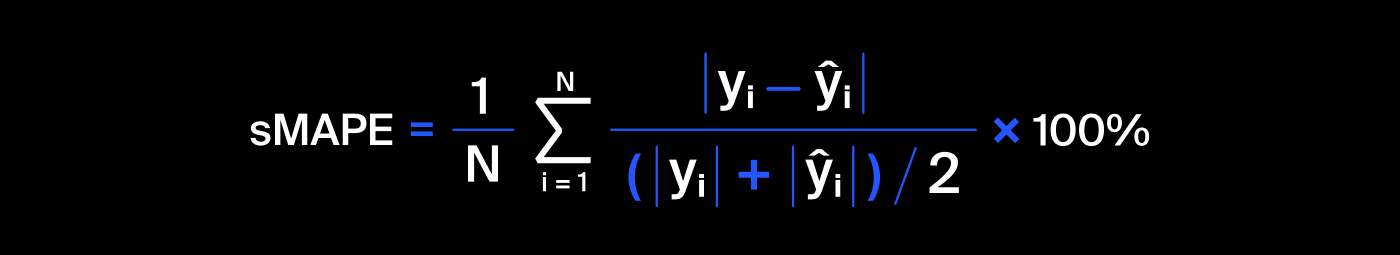

In [53]:
# функция для вычисления sMAPE
def sMAPE(target, predict):
    fail = round(np.mean(np.abs(predict - target) / ((np.abs(predict) + np.abs(target))/2))*100, 3)
    return fail

#### Итоговая метрика складывается из двух величин:

- эффективность обогащения чернового концентрата **rougher.output.recovery**
- эффективность обогащения финального концентрата **final.output.recovery**

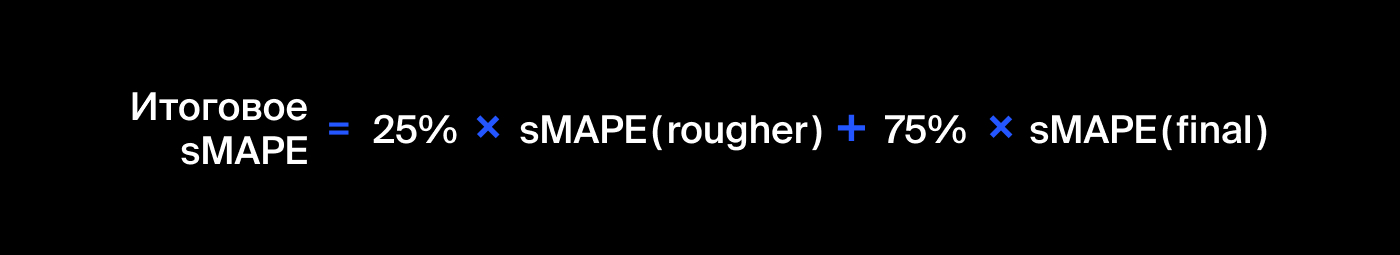

In [54]:
# функция для вычисления итоговой метрики final_sMAPE
def final_sMAPE(sMAPE_roug, sMAPE_final):
    final_fail = round((0.25*sMAPE_roug + 0.75*sMAPE_final), 3)
    return final_fail

### 3.2. Обучим разные модели и оценим их качество кросс-валидацией

### 3.3. Подготовим pipeline

In [55]:
# создадим pipeline с масштабированием признаков для каждой модели регрессии
lr_model = make_pipeline(MinMaxScaler(), LinearRegression())
dtr_model= make_pipeline(MinMaxScaler(), DecisionTreeRegressor(random_state=RANDOM_STATE))
rfr_model= make_pipeline(MinMaxScaler(), RandomForestRegressor(random_state=RANDOM_STATE))

In [56]:
display(lr_model)
display(dtr_model)
display(rfr_model)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [57]:
# создадим оценщик на основе собственной функции
sMAPE_score = make_scorer(sMAPE, greater_is_better=False)

### 3.4. Установим параметры GridSearchCV

In [58]:
# определяем параметры для перебора в GridSearchCV
parametrs_lr  = {} 
parametrs_dtr = {'decisiontreeregressor__max_depth': range (1, 10)}
parametrs_rfr = {'randomforestregressor__n_estimators': range (1, 51, 5),
                 'randomforestregressor__max_depth': range (1, 10)} 

In [59]:
# передаем модели, параметры и оценщика в GridSearchCV
lr_grid_roug  = GridSearchCV(lr_model, param_grid = parametrs_lr, scoring=sMAPE_score)
lr_grid_final = GridSearchCV(lr_model, param_grid = parametrs_lr, scoring=sMAPE_score)

In [60]:
dtr_grid_roug = GridSearchCV(dtr_model, param_grid = parametrs_dtr, scoring=sMAPE_score)
dtr_grid_final= GridSearchCV(dtr_model, param_grid = parametrs_dtr, scoring=sMAPE_score)

In [61]:
rfr_grid_roug = GridSearchCV(rfr_model, param_grid = parametrs_rfr, scoring=sMAPE_score)
rfr_grid_final= GridSearchCV(rfr_model, param_grid = parametrs_rfr, scoring=sMAPE_score)

### 3.5. Обучим модели и найдем лучшие параметры

In [62]:
%%time
lr_grid_roug.fit(features_train_roug, target_train_roug)
lr_grid_final.fit(features_train_final, target_train_final)

CPU times: total: 1.08 s
Wall time: 295 ms


GridSearchCV(estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [63]:
%%time
dtr_grid_roug.fit(features_train_roug, target_train_roug)
dtr_grid_final.fit(features_train_final, target_train_final)

CPU times: total: 22.3 s
Wall time: 21.7 s


GridSearchCV(estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': range(1, 10)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [64]:
%%time
rfr_grid_roug.fit(features_train_roug, target_train_roug)
rfr_grid_final.fit(features_train_final, target_train_final)

CPU times: total: 47min 29s
Wall time: 47min 42s


GridSearchCV(estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': range(1, 10),
                         'randomforestregressor__n_estimators': range(1, 51, 5)},
             scoring=make_scorer(sMAPE, greater_is_better=False))

#### Параметры лучших моделей

In [65]:
print('\033[1m'+ 'Модель "Линейная регрессия"'+'\033[0m')
print('Параметры для "Черновой концентрат": ', lr_grid_roug.best_estimator_)
print('Параметры для "Финальный концентрат":', lr_grid_final.best_estimator_)
print('='*90)
print('\033[1m'+ 'Модель "Регрессия дерева решений"'+'\033[0m')
print('Параметры для "Черновой концентрат": ', dtr_grid_roug.best_estimator_)
print('Параметры для "Финальный концентрат":', dtr_grid_final.best_estimator_)
print('='*90)
print('\033[1m'+ 'Модель "Регрессия случайного леса"'+'\033[0m')
print('Параметры для "Черновой концентрат": ', rfr_grid_roug.best_estimator_)
print('Параметры для "Финальный концентрат":', rfr_grid_final.best_estimator_)
print('='*90)

Модель "Линейная регрессия"
Параметры для "Черновой концентрат":  Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])
Параметры для "Финальный концентрат": Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])
Модель "Регрессия дерева решений"
Параметры для "Черновой концентрат":  Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=3, random_state=42))])
Параметры для "Финальный концентрат": Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=2, random_state=42))])
Модель "Регрессия случайного леса"
Параметры для "Черновой концентрат":  Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=3, n_estimators=26,
      

#### Результаты моделей

In [66]:
# выведем результаты моделей для каждого целевого признака
print('\033[1m'+ 'Модель "Линейная регрессия"'+'\033[0m')
print('Черновой концентрат sMape: ', '\033[1m'+ f'{lr_grid_roug.best_score_:,.3f}' +'\033[0m')
print('Финальный концентрат sMape:', '\033[1m'+ f'{lr_grid_final.best_score_:,.3f}' +'\033[0m')
print('='*36)
print('\033[1m'+ 'Модель "Регрессия дерева решений"'+'\033[0m')
print('Черновой концентрат sMape: ', '\033[1m'+ f'{dtr_grid_roug.best_score_:,.3f}' +'\033[0m')
print('Финальный концентрат sMape:', '\033[1m'+ f'{dtr_grid_final.best_score_:,.3f}' +'\033[0m')
print('='*36)
print('\033[1m'+ 'Модель "Регрессия случайного леса"'+'\033[0m')
print('Черновой концентрат sMape: ', '\033[1m'+ f'{rfr_grid_roug.best_score_:,.3f}' +'\033[0m')
print('Финальный концентрат sMape:', '\033[1m'+ f'{rfr_grid_final.best_score_:,.3f}' +'\033[0m')
print('='*36)

Модель "Линейная регрессия"
Черновой концентрат sMape:  -12.407
Финальный концентрат sMape: -12.215
Модель "Регрессия дерева решений"
Черновой концентрат sMape:  -12.125
Финальный концентрат sMape: -10.526
Модель "Регрессия случайного леса"
Черновой концентрат sMape:  -11.600
Финальный концентрат sMape: -10.245


### 3.6. Выберем лучшую модель и проверим её на тестовой выборке

In [67]:
# выведем результаты моделей для итогового sMape
print('\033[1m'+ 'Модель "Линейная регрессия"'+'\033[0m')
print('Итоговое sMape: ', '\033[1m'+ f'{final_sMAPE(lr_grid_roug.best_score_, lr_grid_final.best_score_):,.3f}' +'\033[0m')
print('='*36)
print('\033[1m'+ 'Модель "Регрессия дерева решений"'+'\033[0m')
print('Итоговое sMape: ', '\033[1m'+ f'{final_sMAPE(dtr_grid_roug.best_score_, dtr_grid_final.best_score_):,.3f}' +'\033[0m')
print('='*36)
print('\033[1m'+ 'Модель "Регрессия случайного леса"'+'\033[0m')
print('Итоговое sMape: ', '\033[1m'+ f'{final_sMAPE(rfr_grid_roug.best_score_, rfr_grid_final.best_score_):,.3f}' +'\033[0m')
print('='*36)

Модель "Линейная регрессия"
Итоговое sMape:  -12.263
Модель "Регрессия дерева решений"
Итоговое sMape:  -10.925
Модель "Регрессия случайного леса"
Итоговое sMape:  -10.584


### 3.7. Модель с лучшим итоговым sMape - "Регрессия случайного леса"

**Параметры для "Черновой концентрат":**

- RandomForestRegressor(max_depth=3, n_estimators=26)

**Параметры для "Финальный концентрат":**

- RandomForestRegressor(max_depth=2, n_estimators=16)

### 3.8. Проверим модель на тестововой выборке

In [68]:
# создадим модели для каждого целевого признака с лучшими параметрами
roug_rfr_model = RandomForestRegressor(max_depth=3, n_estimators=26, random_state=RANDOM_STATE)

final_rfr_model= RandomForestRegressor(max_depth=2, n_estimators=16, random_state=RANDOM_STATE)

In [69]:
%time
# обучим модель для каждого целевого признака
roug_rfr_model.fit(features_train_roug, target_train_roug)

CPU times: total: 0 ns
Wall time: 0 ns


RandomForestRegressor(max_depth=3, n_estimators=26, random_state=42)

In [70]:
%time
final_rfr_model.fit(features_train_final, target_train_final)

CPU times: total: 0 ns
Wall time: 0 ns


RandomForestRegressor(max_depth=2, n_estimators=16, random_state=42)

In [71]:
%time
# получим предсказаная на тестовой выборке для ougher.output.recovery
roug_test_predictions = roug_rfr_model.predict(features_test_roug)

# получим предсказания на тестовой выборке для final.output.recovery
final_test_predictions = final_rfr_model.predict(features_test_final)

CPU times: total: 0 ns
Wall time: 0 ns


In [72]:
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print('Итоговое sMape: ', '\033[1m'+ f'{final_sMAPE(sMAPE(target_test_roug, roug_test_predictions), sMAPE(target_test_final, final_test_predictions)):,.3f}' +'\033[0m')

Тестовая выборка
Итоговое sMape:  9.339


### 3.9. Проверим модель на адекватность

In [73]:
# константная моедль
dummy_model_roug = DummyRegressor()
dummy_model_final= DummyRegressor()

In [74]:
# обучим модель
dummy_model_roug.fit(features_train_roug, target_train_roug)
dummy_model_final.fit(features_train_final, target_train_final)

DummyRegressor()

In [75]:
# получим предсказания и оценку 
roug_test_predictions_dummy  = dummy_model_roug.predict(features_test_roug)
final_test_predictions_dummy = dummy_model_final.predict(features_test_final)

print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print(
    'Итоговое sMape для модели DummyRegressor: ',
    '\033[1m'+ f'{final_sMAPE(sMAPE(target_test_roug, roug_test_predictions_dummy), sMAPE(target_test_final, final_test_predictions_dummy)):,.3f}' +'\033[0m'
)

Тестовая выборка
Итоговое sMape для модели DummyRegressor:  10.297


Итоговое sMAPE для DummyRegressor: 10.297.\
У лучшей модели "Регрессия случайного леса" значение sMape: 9.339.\
Это лучше среднего значения DummyRegressor и значит, что наша модель адекватна.

# Выводы

1. Проведено исследование данных технологического процесса обогащения золотосодержащей руды.
2. Итоговая оценка работы модели складывается из оценок по двум целевым признакам:
    - эффективность обогащения чернового концентрата rougher.output.recovery
    - эффективность обогащения финального концентрата final.output.recovery
3. Данные подготовленны, разбиты на выборки в зависимости от этих целевых признаков.
4. Для каждого целевого признака исследованы три модели для задачи регрессии:
    - "Логическая регрессия"
    - "Регрессия дерева решений"
    - "Регрессия случайного леса"
5. Найдена лучшая модель и параметры для неё для каждого целевого признака:
    - модель и параметры для признака "Черновой концентрат": RandomForestRegressor(max_depth=3, n_estimators=26)
    - модель и параметры для признака "Финальный концентрат": RandomForestRegressor(max_depth=5, n_estimators=36)
6. Проведена проверка лучшей модели на тестовой выборке:
    - итоговое sMape:  9.339
7. sMape можно интерпретировать как процент, на который мы ошиблись при прогнозе
8. Модель прошла проверку на адекватность.